**Goal of the project**

In this notebook, we will classify Wikipedia comments into one or more categories of so-called toxic comments. Categories of toxic online behavior include toxic, severe_toxic, obscene, threat, insult, and identity_hate. The dataset can be downloaded from the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge) as a CSV file (i.e., download the file train.csv).

In [9]:
# Importing libraries
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text

**Load and preprocess data**

We will load the data using the texts_from_csv function. This function expects one column to contain the texts of documents and one or more other columns to store the labels.

Since val_filepath is None, 10% of the data will automatically be used as a validation set.

In [10]:
# Load and preprocess data
DATA_PATH = '../input/jigsaw-toxic-comment-classification-challenge/train.csv'
NUM_WORDS = 50000
MAXLEN = 150

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_csv(DATA_PATH, 'comment_text',
                                                                    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                                                                    val_filepath = None, 
                                                                    max_features = NUM_WORDS, 
                                                                    maxlen = MAXLEN,
                                                                    ngram_range = 1)

detected encoding: utf-8 (if wrong, set manually)
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        toxic  severe_toxic  obscene  threat  insult  identity_hate
75451       0             0        0       0       0              0
134020      0             0        0       0       0              0
80906       0             0        0       0       0              0
10836       0             0        1       0       1              0
5198        0             0        0       0       0              0
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        toxic  severe_toxic  obscene  threat  insult  identity_hate
77254       0             0        0       0       0              0
94717       0             0        0       0       0              0
128171      0             0        1       0       0              0
119455      0             0        0       0       0              0
38298       0             0        0       0       0  

**Build a text classification model**

Having loaded the data, we will now create a text classification model. The print_text_classifiers function prints some available models.

In [11]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [12]:
# Load a fastText model
model = text.text_classifier('fasttext', (x_train, y_train), preproc = preproc)

Is Multi-Label? True
compiling word ID features...
maxlen is 150
done.


Next, we load a text classification model and wrap the model and data in Learner object. 

In [13]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = (x_train, y_train), val_data = (x_test, y_test), batch_size = 256)

**Estimate a good learning rate**

To train the model, we will first find the optimal learning rate that suits well to our problem. ktrain provides a very good method named lr_find which trains the model at different learning rates and plots loss of the model as the learning rate is increased.

In [14]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 3) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
561/561 [==============================] - 4s 6ms/step - loss: 0.6745 - accuracy: 0.0625
Epoch 2/3
561/561 [==============================] - 4s 6ms/step - loss: 0.2841 - accuracy: 0.3333
Epoch 3/3
561/561 [==============================] - 3s 5ms/step - loss: 4.4795 - accuracy: 0.7992


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


The learning rate plot can be observed by calling the following method:

Three possible suggestions for LR from plot:
	Longest valley (red): 2.50E-04
	Min numerical gradient (purple): 1.52E-02
	Min loss divided by 10 (omitted from plot): 2.27E-02


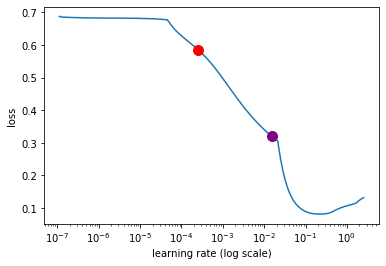

In [15]:
# Visually identify best learning rate
learner.lr_plot(suggest = True)

**Train**

We will now train the model using the autofit method. The method trains the classifier and automatically selects the best performing one preventing underfitting and overfitting of the model.

In [17]:
# Training using the autofit policy
learner.autofit(2.50E-04, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.00025...
Epoch 1/1024
561/561 [==============================] - 5s 8ms/step - loss: 0.4040 - accuracy: 0.0895 - val_loss: 0.3063 - val_accuracy: 0.2215
Epoch 2/1024
561/561 [==============================] - 4s 8ms/step - loss: 0.1800 - accuracy: 0.2189 - val_loss: 0.1213 - val_accuracy: 0.7904
Epoch 3/1024
561/561 [==============================] - 4s 7ms/step - loss: 0.1235 - accuracy: 0.3948 - val_loss: 0.0812 - val_accuracy: 0.9698
Epoch 4/1024
561/561 [==============================] - 4s 8ms/step - loss: 0.0961 - accuracy: 0.5457 - val_loss: 0.0671 - val_accuracy: 0.9902
Epoch 5/1024
561/561 [==============================] - 4s 7ms/step - loss: 0.0825 - accuracy: 0.6794 - val_loss: 0.0619 - val_accuracy: 0.9929
Epoch 6/1024
561/561 [==============================] - 4s 8ms/step - loss: 0.0744 - accuracy: 0.7844 - val_loss: 0.0591 - val_accuracy: 0.9939
E

**Making predictions**

In [18]:
y_pred = learner.model.predict(x_test)

**Evaluate model**

Let's compute for ROC-AUC of our final model for identifying toxic online behavior:

In [19]:
from sklearn.metrics import roc_auc_score

In [25]:
# Evaluate model
score = roc_auc_score(y_test, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.975853 



Our final ROC-AUC score is **0.98**.